In [6]:
from __future__ import print_function
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

from nn_transfer import transfer, util

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import os
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D,BatchNormalization, Deconv2D, ZeroPadding2D
import tensorflow as tf
from keras.models import Model
K.set_image_data_format('channels_first')

# import sys
# sys.path.append("/home/yl/utils/")
# sys.path.append("/home/yl/ssd.pytorch/")
# from ssd import build_ssd
# from unet import UNet2
# from densenet020 import densenet169
from densenet import densenet169
%matplotlib inline

In [5]:
'''
import sys
sys.path.append('/home/wrj/deeplearning/')
from gpu_allocation import set_gpu
num_gpu = 1
set_gpu(num_gpu,gpu_list=[0,1,2,3,4,5,6,7])
'''
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"

"\nimport sys\nsys.path.append('/home/wrj/deeplearning/')\nfrom gpu_allocation import set_gpu\nnum_gpu = 1\nset_gpu(num_gpu,gpu_list=[0,1,2,3,4,5,6,7])\n"

In [7]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [8]:
class Densenet_keras(object):
    def __init__(self, n=3, n_out=64):
        self.n = n
        self.n_out = n_out
        
    def Squential(self, input_tensor, n_out, kernel_size=(7,7), strides=(2,2)):
        name = "features."
        x = input_tensor
        x = ZeroPadding2D((3, 3))(x)
        x = Conv2D(n_out, kernel_size,
                   strides=strides, padding="valid", 
                   use_bias=False,
                   name = name+"conv0")(x)
        x = BatchNormalization(axis=1, name=name+"norm0")(x)
        x = Activation("relu")(x)
        x = ZeroPadding2D((1, 1))(x)
        x = MaxPooling2D((3, 3), (2, 2), padding="valid", name=name+"pool0")(x)
        return x
            
    def _DenseLayer(self, input_tensor, n_out, pre, num, 
                    kernel_size1=(1,1), kernel_size3=(3,3), strides=(1,1)):
        if num > 0:
            name = "%s.denselayer%d." % (pre, num)
        else:
            name = "%s."% pre
        x = input_tensor
        x = BatchNormalization(axis=1, name=name+"norm1")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, kernel_size1,
                   strides=strides, padding="valid", 
                   use_bias=False,
                   name = name+"conv1")(x)
        x = BatchNormalization(axis=1, name=name+"norm2")(x)
        x = Activation("relu")(x)
        x = Conv2D(n_out, kernel_size3,
                  strides=strides, padding="same", 
                   name = name+"conv2")(x)  
        return x
    
    def _DenseBlock(self, input_tensor, n_out, numb, numl):
        x = input_tensor
        name = "features.denseblock%d" % numb
        for n in range(numl):
            x_ = self._DenseLayer(x, n_out, name, n+1, (1,1), (3,3), (1,1))
            x = concatenate([x, x_], axis=1)
        return x

    def _Transition(self, input_tensor, n_out, numt):
        name = "features.transition%d." % numt
        x = input_tensor
        x = BatchNormalization(axis=1, name=name+"norm")(x)
        x = Activation("relu")(x)
        x = Conv2D(n_out, kernel_size=(1,1),
                   strides=(1,1), padding="valid", 
                   use_bias=False,
                   name = name+"conv")(x)        
        x = AveragePooling2D((2, 2), (2, 2), padding="valid", name=name+"pool")(x)
        return x
    
    def densenet(self, input_tensor, input_shape, classes):
        if input_tensor is None:
            input_tensor = Input(shape = input_shape)
        x = input_tensor
        convsize = 32
        seq = self.Squential(x, self.n_out)
        denb1 = self._DenseBlock(seq, convsize, 1, 6)
        tran1 = self._Transition(denb1, 128, 1)
        denb2 = self._DenseBlock(tran1, convsize, 2, 12)
        tran2 = self._Transition(denb2, 256, 2)
        denb3 = self._DenseBlock(tran2, convsize, 3, 32)
        tran3 = self._Transition(denb3, 640, 3)
        denb4 = self._DenseBlock(tran3, convsize, 4, 32)
        name = "features."
        norm5 = BatchNormalization(axis=1, name=name+"norm5")(denb4)
        norm5 = Activation('relu')(norm5)
        gap = GlobalAveragePooling2D()(norm5)
        classes = classes
        classifier = Dense(classes, use_bias=True, name='classifier')(gap)      
        model = Model(input_tensor, classifier, name="dense_keras")
        return model
        

In [9]:
dk = Densenet_keras(3, 64)
kmodel = dk.densenet(None, (3, 224, 224), 3)

ValueError: Initializer for variable features.conv0_1/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

In [6]:
keras.__version__

'2.2.4'

In [33]:
kmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 224, 224)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 3, 230, 230)  0           input_2[0][0]                    
__________________________________________________________________________________________________
features.conv0 (Conv2D)         (None, 64, 112, 112) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
features.norm0 (BatchNormalizat (None, 64, 112, 112) 256         features.conv0[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_279 (Activation)     (None, 128, 7, 7)    0           features.denseblock4.denselayer3.
__________________________________________________________________________________________________
features.denseblock4.denselayer (None, 32, 7, 7)     36896       activation_279[0][0]             
__________________________________________________________________________________________________
concatenate_135 (Concatenate)   (None, 736, 7, 7)    0           concatenate_134[0][0]            
                                                                 features.denseblock4.denselayer3.
__________________________________________________________________________________________________
features.denseblock4.denselayer (None, 736, 7, 7)    2944        concatenate_135[0][0]            
__________________________________________________________________________________________________
activation

In [10]:
# import os
# det_net = densenet169()
# num_ftrs = det_net.classifier.in_features
# det_net.classifier = nn.Linear(num_ftrs, 2)
# ckpt = os.path.join('/data/model_weights/slf/point_cut/045.ckpt')
# checkpoint = torch.load(ckpt)
# det_net.load_state_dict(checkpoint["state_dict"])
# print("model loaded")
# #det_net.cuda()


[[[[211 205 202 ... 106  50  54]
   [210 204 202 ... 108  52  59]
   [216 213 210 ... 106  50  57]
   ...
   [209 209 209 ...  92  81  77]
   [209 208 208 ... 129 107  90]
   [209 208 208 ... 164 149 131]]

  [[218 210 205 ... 130  90 109]
   [218 211 205 ... 132  92 111]
   [228 221 214 ... 128  86 105]
   ...
   [223 223 223 ... 105  94  91]
   [223 222 222 ... 145 123 106]
   [223 222 222 ... 182 167 149]]

  [[226 216 210 ... 117  63  69]
   [229 221 212 ... 119  65  72]
   [242 234 225 ... 116  60  67]
   ...
   [236 236 236 ... 121 110 104]
   [236 235 235 ... 160 136 119]
   [236 235 235 ... 194 179 161]]]]
(1, 3, 224, 224)


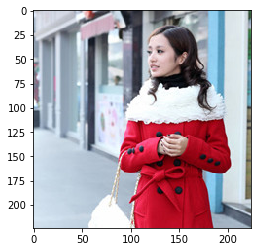

In [34]:
# Create dummy data
#data = torch.rand(1,3,224,224)
#data_save = data.numpy()
#np.save("./model/input_tmp.npy",data_save)
# Do a forward pass in both frameworks
# keras_pred = kmodel.predict(data_keras)
#pytorch_pred = pmodel(data_pytorch).data.numpy()
# pytorch_pred = torch.nn.Softmax(dim=1)(pytorch_pred).data.numpy()
import cv2
import matplotlib.pyplot as plt
def cvt(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

data = cvt(cv2.imread("/home/shiyi/keras/img.jpg"))
plt.imshow(data)

data = data#*1.0/255

data = data[np.newaxis, ...]
data = np.transpose(data,(0,3,1,2))
print(data)
print(np.shape(data))
data_keras = np.copy(data)
#print(data_keras)

In [35]:
pmodel = densenet169(pretrained=False)
num_classes = 3
num_ftrs = pmodel.classifier.in_features
pmodel.classifier = nn.Linear(num_ftrs, num_classes)
pmodel.load_state_dict(torch.load("model/dense169_best.pth",map_location='cpu'))
pmodel.eval()
data_torch = torch.FloatTensor(data)
pytorch_pred = pmodel(data_torch).data
print("torch_out:",pytorch_pred)

torch_out: tensor([[ 104.7901, -380.2689, -155.9626]])


In [ ]:
transfer.pytorch_to_keras(pmodel, kmodel, verbose=False)
keras_pred = kmodel.predict(data_keras)
print("keras_out:",keras_pred)
kmodel.save("model/dense169_best.h5")

In [ ]:
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
from tensorflow.python.framework import graph_io
 
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph
 
 
h5_model_path='./model/densenet169_best.h5'
output_path='./model/'
pb_model_name='densenet169_best.pb'
K.set_learning_phase(0)
net_model = load_model(h5_model_path)
 
print('input is :', net_model.input.name)
print ('output is:', net_model.output.name)
 
sess = K.get_session()
frozen_graph = freeze_session(K.get_session(), output_names=[net_model.output.op.name])
graph_io.write_graph(frozen_graph, output_path, pb_model_name, as_text=False)

In [24]:


from keras.models import load_model
import tensorflow as tf
import os 
import os.path as osp
from keras import backend as K
#路径参数
input_path = './model/'
weight_file = 'densenet169_best.hdf5'
weight_file_path = osp.join(input_path,weight_file)
output_graph_name = weight_file[:-3] + '.pb'
#转换函数
def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        print(out_prefix + str(i + 1))
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)
#输出路径
output_dir = osp.join(os.getcwd(),"./model")
#加载模型
h5_model = load_model(weight_file_path)
h5_to_pb(h5_model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')


output_1
INFO:tensorflow:Froze 928 variables.
INFO:tensorflow:Converted 928 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/home/shiyi/keras/./model
model saved


In [ ]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
import warnings
warnings.filterwarnings("ignore")
cur_path = os.getcwd()

pb_file_path = "./model/densenet169/densenet169_best.pb"
img_file_path = "/home/shiyi/keras/img.jpg"
#input_tmp = np.load(np_file_path)
#input_tmp = np.ones([1,3,224,224])
#print(np.shape(input_tmp))

image_data = tf.placeholder(tf.float32,  shape=(1, 3, 224, 224))
image = cv2.imread(img_file_path)
image[:,:,[0,2]] = image[:,:,[2,0]]
image = image[np.newaxis, ...]
image = image.transpose(0, 3, 1, 2)

# image_data = tf.gfile.FastGFile(img_file_path,'rb').read()
# image_data = tf.image.decode_jpeg(image_data)
# image_data = tf.expand_dims(image_data, 0)
# image_data = tf.transpose(image_data, [0, 3, 1, 2])
#image_data = tf.image.resize_images(image_data, (224,224), method=0)
# t =tf.shape(image_data)

with tf.Session() as sess:
    #print(sess.run(image_data)/255.)
    image_data = sess.run(image_data, feed_dict={image_data:image})#/255.
    #image_data = image_data.eval(session=sess)
#print(image_data)

sess = tf.Session()
with tf.gfile.GFile(pb_file_path, 'rb') as f: #加载模型
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')  # 导入计算图


# 需要先复原变量
input_x = sess.graph.get_tensor_by_name('input_1_1:0')  #此处的x一定要和之前保存时输入的名称一致！
op = sess.graph.get_tensor_by_name('classifier_1/BiasAdd:0')  #此处的op_to_store一定要和之前保存时输出的名称一致！
ret = sess.run(op, feed_dict={input_x: image_data})
print(ret)


In [68]:
!ls -all ./model

total 306340
drwxr-xr-x 3 shiyi root      4096 Aug 19 10:27 .
drwxr-xr-x 5 shiyi root      4096 Aug 19 10:27 ..
-rw-r--r-- 1 shiyi root  50727480 Feb  1  2019 dense169_best.pth
drwxr-xr-x 2 shiyi root      4096 Aug 15 15:47 densenet169
-rw-r--r-- 1 shiyi root  52244496 Aug 15 15:06 densenet169_best.hdf5
-rw-r--r-- 1 shiyi root  52859571 Aug 19 10:27 densenet169_best.h.pb
-rw-r--r-- 1 shiyi root 103678261 Aug 15 15:32 densenet169_best.pb
-rw-r--r-- 1 shiyi root  53543850 Aug 19 10:27 events.out.tfevents.1566181674.172-16-1-231
-rw-r--r-- 1 shiyi root    602240 Aug 15 16:49 input_tmp.npy


In [7]:
from keras.models import load_model
kmodel = load_model("onfh_oa_ddh_densenet169.hdf5")
keras_pred = kmodel.predict(data_keras)
keras_pred

C:\Users\polaris\Anaconda3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


array([[-1.3754523, -4.6430173,  5.797166 ]], dtype=float32)

In [8]:
def softmax(array):
    exp_array = np.exp(array)
    return exp_array / exp_array.sum()

In [9]:
softmax(keras_pred)

array([[7.6670042e-04, 2.9210585e-05, 9.9920410e-01]], dtype=float32)

In [168]:
def get_features_hook(self, input, output):
    print("hook",output.data.cpu().numpy())
handle=pmodel.features.norm5.register_forward_hook(get_features_hook)
pmodel(data_pytorch).data.numpy()

hook [[[[-6.76472858e-03  2.77472165e-04  1.14724346e-04 ... -3.69079440e-04
    -3.33398784e-04 -8.87784082e-03]
   [-9.62587597e-04 -3.23238055e-04 -1.54368841e-04 ... -1.33088813e-03
    -6.19091385e-04 -3.11783841e-03]
   [-3.28074838e-03  9.41707462e-04  7.66657584e-04 ...  2.81921384e-04
    -1.68046495e-03 -2.34049326e-03]
   ...
   [-3.43558216e-03  3.49033915e-04 -1.03318889e-03 ...  4.74424218e-04
     7.24900630e-04 -3.48654063e-03]
   [-2.82550137e-03  4.10907116e-04  8.15266976e-04 ...  1.56800408e-04
     5.63505630e-04 -2.11003795e-03]
   [-3.84422694e-03  5.57029271e-04  9.81468009e-04 ... -5.45475283e-04
    -4.24046069e-04 -3.92019423e-03]]

  [[-5.38195064e-03 -3.49248963e-04  2.68638978e-04 ... -2.51833146e-04
     9.51391354e-04 -7.80642126e-03]
   [ 1.49763143e-03  2.72129732e-03  1.50814676e-03 ...  6.06610192e-05
     2.06491468e-03 -5.80190914e-04]
   [-1.39385200e-04  1.55550172e-03 -1.59922085e-04 ... -4.81135619e-04
     1.96182547e-04 -1.15900417e-03]
   ..

array([[-0.28920373, -4.3708677 ,  5.8269567 ]], dtype=float32)

In [223]:
kmodel.save("onfh_oa_ddh_densenet169.hdf5")

In [ ]:
from keras.models import load_model
kmodel = load_model("onfh_oa_ddh_densenet169.hdf5")

In [169]:
from keras.models import Model
model = kmodel # 创建原始模型 原来你的那个模型，不变
layer_name = 'features.norm5'#你想要获得输出的原始模型中那一层的名称
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)#你创建新的模型
#这个新的模型截取了原始模型中从输入到某个层（你想要得到结果的那一层）的一部分，
intermediate_output = intermediate_layer_model.predict(data_keras)#这个数据就是原始模型的输入数据，
intermediate_output

array([[[[-6.76472578e-03,  2.77472020e-04,  1.14725553e-04, ...,
          -3.69080459e-04, -3.33395088e-04, -8.87783244e-03],
         [-9.62590100e-04, -3.23238317e-04, -1.54367532e-04, ...,
          -1.33088778e-03, -6.19092025e-04, -3.11783748e-03],
         [-3.28074861e-03,  9.41705774e-04,  7.66655372e-04, ...,
           2.81921064e-04, -1.68046344e-03, -2.34049233e-03],
         ...,
         [-3.43558146e-03,  3.49034788e-04, -1.03318726e-03, ...,
           4.74424596e-04,  7.24899117e-04, -3.48654203e-03],
         [-2.82550184e-03,  4.10905806e-04,  8.15266161e-04, ...,
           1.56800088e-04,  5.63505688e-04, -2.11003795e-03],
         [-3.84422578e-03,  5.57028688e-04,  9.81465913e-04, ...,
          -5.45475865e-04, -4.24047117e-04, -3.92019795e-03]],

        [[-5.38194785e-03, -3.49248294e-04,  2.68638949e-04, ...,
          -2.51834863e-04,  9.51394089e-04, -7.80642219e-03],
         [ 1.49762933e-03,  2.72129849e-03,  1.50814711e-03, ...,
           6.06630929e